In [22]:
import os
import cv2
import numpy as np
import redis
from redis.commands.search.field import VectorField
from redis.commands.search.query import Query
from deepface import DeepFace
import pickle 

In [23]:
# Initialize Redis connection
r = redis.Redis(
    host="redis-12197.c264.ap-south-1-1.ec2.cloud.redislabs.com",  
    port=12197,  
    password="kDXeoDGEtVVnrryo145lK89ZXbwlSFML",  
    ssl=False,
)

In [49]:
# Name of the index
index_name = "embedding_index"

try:
    r.ft().create_index(
        [
            VectorField(
                "embedding",
                "HNSW",
                {
                    "TYPE": "FLOAT32",
                    "DIM": 128,
                    "DISTANCE_METRIC": "L2",
                },
            )
        ]
    )
except redis.exceptions.ResponseError as e:
    if "Index already exists" not in str(e):
        raise

In [50]:

dataset_dir = "dataset_test"
embeddings_file = "embeddings.pkl"

if os.path.exists(embeddings_file):
    with open(embeddings_file, "rb") as f:
        embeddings = pickle.load(f)
else:
    embeddings = {}


In [51]:
def save_embeddings():
    with open(embeddings_file, "wb") as f:
        pickle.dump(embeddings, f)


In [52]:
# Function to extract embeddings from an image
def extract_embeddings(image_path):
    if image_path not in embeddings:
        embedding = DeepFace.represent(
            img_path=image_path,
            model_name="Facenet",
            detector_backend="mtcnn",
        )[0]["embedding"]
        embeddings[image_path] = embedding
        print(f"Embedding created for image: {image_path}")
        save_embeddings()  # Save the embeddings to the file
    return np.array(embeddings[image_path]).astype(np.float32).tobytes()



In [53]:
for filename in os.listdir(dataset_dir):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(dataset_dir, filename)
        
        if filename not in embeddings:
            try:
                embedding = extract_embeddings(image_path)
                embeddings[filename] = embedding
                print(f"Embedding created for image: {filename}")
            except Exception as e:
                print(f"No face detected in image: {filename}")

In [16]:
# # Save the embeddings to a file
# with open(embeddings_file, "wb") as f:
#     pickle.dump(embeddings, f)

In [43]:
def find_similar_image(query_image_path, similarity_threshold=0.9):
    query_vector = extract_embeddings(query_image_path)
    
    # Use cosine similarity as the similarity metric
    base_query = f"*=>[KNN 1 @embedding $query_vector AS cosine_similarity]"
    query = Query(base_query).return_fields("cosine_similarity").sort_by("cosine_similarity").dialect(2)
    
    results = r.ft().search(query, query_params={"query_vector": query_vector})
    
    for result in results.docs:
        cosine_similarity_str = result['cosine_similarity']  
        cosine_similarity = float(cosine_similarity_str) 

        print(f"Cosine Similarity: {cosine_similarity}")
        if cosine_similarity >= similarity_threshold:
            most_similar_image_key = result.id
            return most_similar_image_key
    
    return None  # No similar images found

# Example usage with adjusted similarity threshold (0.9)
query_image_path = "eval/tom1.jpg"
most_similar_image_key = find_similar_image(query_image_path, similarity_threshold=0.9)

if most_similar_image_key:
    most_similar_image_path = os.path.join(dataset_dir, most_similar_image_key)
    most_similar_image = cv2.imread(most_similar_image_path)
    print("Most Similar Image:", most_similar_image_key)
    display(Image(filename=most_similar_image_path))
else:
    print("No similar image found.")

Embedding created for image: eval/tom1.jpg
Cosine Similarity: 0.0
No similar image found.


In [45]:
from IPython.display import Image, display

query_image_path = "eval/tom1.jpg"
most_similar_image_key = find_similar_image(query_image_path)

if most_similar_image_key:
    most_similar_image_path = os.path.join(dataset_dir, most_similar_image_key)
    most_similar_image = cv2.imread(most_similar_image_path)
    print("Most Similar Image:", most_similar_image_key)
    display(Image(filename=most_similar_image_path))
else:
    print("No similar image found.")


Cosine Similarity: 0.0
No similar image found.


In [46]:
# Function to perform similarity search
def find_similar_image(query_image_path):
    query_vector = extract_embeddings(query_image_path)
    
    base_query = f"*=>[KNN 1 @embedding $query_vector AS distance]"
    query = Query(base_query).return_fields("distance").sort_by("distance").dialect(2)
    
    results = r.ft().search(query, query_params={"query_vector": query_vector})
    
    for result in results.docs:
        most_similar_image_key = result.id
        return most_similar_image_key
    
    return None  # No similar images found



Embedding created for image: eval/Ronald_Reagan_0003.jpg
Most Similar Image: mammoty2.jpg


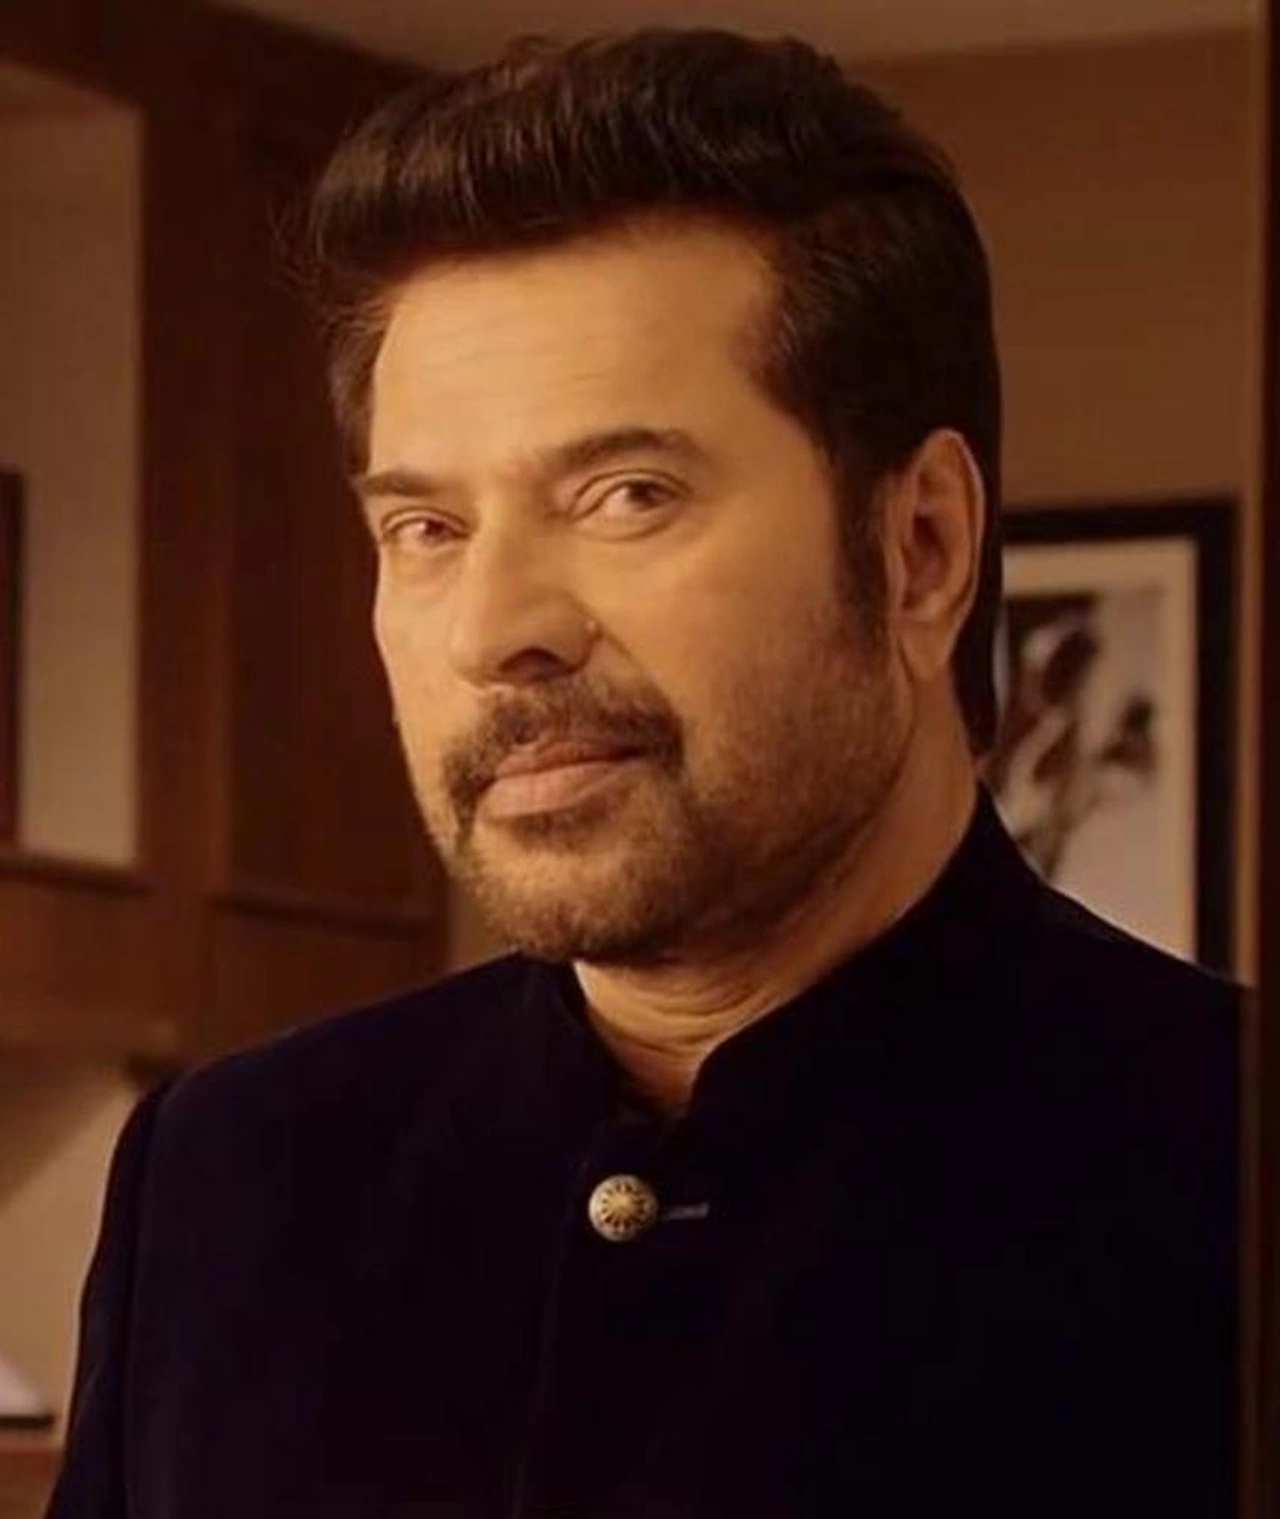

In [54]:
from IPython.display import Image, display

query_image_path = "eval/Ronald_Reagan_0003.jpg"
most_similar_image_key = find_similar_image(query_image_path)

if most_similar_image_key:
    most_similar_image_path = os.path.join(dataset_dir, most_similar_image_key)
    most_similar_image = cv2.imread(most_similar_image_path)
    print("Most Similar Image:", most_similar_image_key)
    display(Image(filename=most_similar_image_path))
else:
    print("No similar image found.")


In [57]:
pip install redis-py-search


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement redis-py-search (from versions: none)
ERROR: No matching distribution found for redis-py-search
Note: you may need to restart the kernel to use updated packages.


In [64]:
import redis
import os
import pickle
import cv2
import numpy as np
from deepface import DeepFace

# Initialize Redis connection
r = redis.Redis(
    host="redis-12197.c264.ap-south-1-1.ec2.cloud.redislabs.com",
    port=12197,
    password="kDXeoDGEtVVnrryo145lK89ZXbwlSFML",
    ssl=False,
)

# Name of the index
index_name = "embedding_index"

# Create or update the index if needed
try:
    r.ft().create_index(
        [
            redis.commands.search.VectorField(
                "embedding",
                "HNSW",
                {
                    "TYPE": "FLOAT32",
                    "DIM": 128,
                    "DISTANCE_METRIC": "L2",
                },
            )
        ],
        index_name,
    )
except redis.exceptions.ResponseError as e:
    if "Index already exists" not in str(e):
        raise

dataset_dir = "dataset_test"
embeddings_file = "embeddings.pkl"

# Load embeddings from the file if it exists
if os.path.exists(embeddings_file):
    with open(embeddings_file, "rb") as f:
        embeddings = pickle.load(f)
else:
    embeddings = {}

# Function to extract embeddings from an image and store in the index
def extract_and_store_embeddings(image_path):
    if image_path not in embeddings:
        try:
            embedding = DeepFace.represent(
                img_path=image_path,
                model_name="Facenet",
                detector_backend="mtcnn",
            )[0]["embedding"]
            embeddings[image_path] = embedding
            print(f"Embedding created for image: {image_path}")

            # Save the embeddings to a file after each new embedding is created
            with open(embeddings_file, "wb") as f:
                pickle.dump(embeddings, f)

            # Store the embedding in the Redis index
            r.ft().add_document(
                index_name,
                image_path,
                fields={"embedding": embedding.tobytes()},
                replace=True,
            )
        except Exception as e:
            print(f"No face detected in image: {image_path}")

# Function to perform similarity search
def find_similar_image(query_image_path):
    query_vector = extract_and_store_embeddings(query_image_path)

    base_query = f"*=>[KNN 1 @embedding $query_vector AS distance]"
    query = r.ft().Query(base_query).return_fields("distance").sort_by("distance")

    results = r.ft().search(index_name, query, query_params={"query_vector": query_vector.tobytes()})

    for result in results.docs:
        most_similar_image_key = result.id
        return most_similar_image_key

    return None  # No similar images found

from IPython.display import Image, display

query_image_path = "eval/mamm.jpg"
most_similar_image_key = find_similar_image(query_image_path)

if most_similar_image_key:
    most_similar_image_path = os.path.join(dataset_dir, most_similar_image_key)
    most_similar_image = cv2.imread(most_similar_image_path)
    print("Most Similar Image:", most_similar_image_key)
    display(Image(filename=most_similar_image_path))
else:
    print("No similar image found.")


AttributeError: module 'redis.commands.search' has no attribute 'VectorField'

In [60]:
pip install redis-py


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement redis-py (from versions: none)
ERROR: No matching distribution found for redis-py
Note: you may need to restart the kernel to use updated packages.
